# Terea 1: Reconocedor basado en whisper

# Imports

In [1]:
import os
import torch
import torch, torchaudio, glob
import soundfile as sf
import numpy as np
import random
import scipy.signal
import csv
import matplotlib.pyplot as plt

from datasets import load_dataset
from IPython.display import Audio, display

from Trabajo_Utils import NoiseAug, RIRAug, identity, plot_spectrogram, wer
from Trabajo_Model import *

/home/giuseppe/.pyenv/versions/hlt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Consts

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEQ_LEN = 12
NB_EPOCHS = 5
BATCH_SIZE = 32

def seed_everything(seed):      
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

### Data Download

In [3]:
dataset = load_dataset("FluidInference/musan", split="train")

if not os.path.exists("musan_small"):
    os.makedirs("musan_small", exist_ok=True)
    for i, example in enumerate(dataset):
        audio = example["audio"]["array"]
        sr = example["audio"]["sampling_rate"]
        sf.write(f"musan_small/file_{i}.wav", audio, sr)
        
url = 'https://openslr.elda.org/resources/28/rirs_noises.zip'

if not os.path.exists('RIRS_NOISES'):
    if not os.path.exists('rirs_noises.zip'):
        os.system('wget ' + url)
    os.system('unzip -q rirs_noises.zip')
    os.system('rm rirs_noises.zip')

Repo card metadata block was not found. Setting CardData to empty.


## 1.1
Aprovechando lo visto en los cuadernos del taller se propone crear un tokenizador adaptado al vocabulario de la tarea. <br>
La idea es que sea orientado a palabra ya que hay pocas y simplifica el reconocimiento. <br> 
Se puede reaprovechar el tokenizador
DigitSumTokenizer que aparece en el cuaderno: parte2/run11. Implemente el
tokenizador para la tarea: <br>
- fechas2/fechas2_train.es.csv <br>
- fechas2/fechas2_test.es.csv <br>

In [4]:
class WordTokenizer:
    def __init__(self, csv_file):
        self.word2index = {
            '<pad>': 0,
            '<sos>': 1,
            '<eos>': 2,
            '<unk>': 3
        }
        self.index2word = {
            0: '<pad>',
            1: '<sos>',
            2: '<eos>',
            3: '<unk>'
        }

        self.build_vocab(csv_file)

    def build_vocab(self, csv_file):
        with open(csv_file, newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                text = row['txt'].lower()
                for word in text.split():
                    if word not in self.word2index:
                        idx = len(self.word2index)
                        self.word2index[word] = idx
                        self.index2word[idx] = word

    def encode(self, text, seq_len=-1):
        tokens = ['<sos>'] + text.lower().split() + ['<eos>']
        ids = [
            self.word2index.get(w, self.word2index['<unk>'])
            for w in tokens
        ]

        if seq_len > len(ids):
            ids += [self.word2index['<pad>']] * (seq_len - len(ids))
        else:
            ids = ids[:seq_len]

        return torch.tensor(ids)


    def decode(self, ids):
        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()

        words = [self.index2word.get(i, '<unk>') for i in ids]
        text = ' '.join(words)
        text = text.replace('<sos>', '').replace('<eos>', '').replace('<pad>', '')
        return text.strip()


## 1.2
Reutilice el contenido del cuaderno part1/run5 para implementar un Trainset y Testset adaptados a la tarea fechas2 que estamos implementando. <br> 
Compruebe de forma similar a como se hace en el cuaderno varios ficheros de train con aumento de ruido aditivo y reverberación con figuras de sus espectrogramas y la posibilidad de escucharlos.

#### Dataset Definitions

In [5]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        csv_file,
        tokenizer,
        audio_len=4*16000,
        seq_len=SEQ_LEN,
        transform=[identity]
    ):
        self.audio_len = audio_len
        self.seq_len = seq_len
        self.transform = transform
        self.tokenizer = tokenizer

        with open(csv_file, encoding='utf-8') as f:
            reader = csv.DictReader(f)
            self.data = [(row['wav'], row['txt']) for row in reader]

        print(len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wav_path, text = self.data[idx]

        x, fs = torchaudio.load(wav_path)

        if x.shape[1] < self.audio_len:
            x = torch.nn.functional.pad(
                x, (0, self.audio_len - x.shape[1]), value=0
            )
        else:
            x = x[:, :self.audio_len]

        x = x[0].numpy()
        for t in self.transform:
            x = t(x)

        y = self.tokenizer.encode(text, self.seq_len)
        return x, y
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, tokenizer, audio_len=4*16000, seq_len=SEQ_LEN):
        self.audio_len = audio_len
        self.seq_len = seq_len
        self.tokenizer = tokenizer

        with open(csv_file, encoding='utf-8') as f:
            reader = csv.DictReader(f)
            self.data = [(row['wav'], row['txt']) for row in reader]

        print(len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wav_path, text = self.data[idx]

        x, fs = torchaudio.load(wav_path)
        if x.shape[1] < self.audio_len:
            x = torch.nn.functional.pad(
                x, (0, self.audio_len - x.shape[1]), value=0
            )
        else:
            x = x[:, :self.audio_len]

        x = x[0]
        y = self.tokenizer.encode(text, self.seq_len)
        return x, y

In [6]:
tokenizer = WordTokenizer('fechas2/fechas2_train.es.csv')
tokenizer.build_vocab('fechas2/fechas2_test.es.csv')

trainset = TrainDataset(
    'fechas2/fechas2_train.es.csv',
    tokenizer,
    transform=[
        NoiseAug(prob=0.5),
        RIRAug(prob=0.5)
    ]
)

testset = TestDataset(
    'fechas2/fechas2_test.es.csv',
    tokenizer
)


10000
1000


### Data Visualization

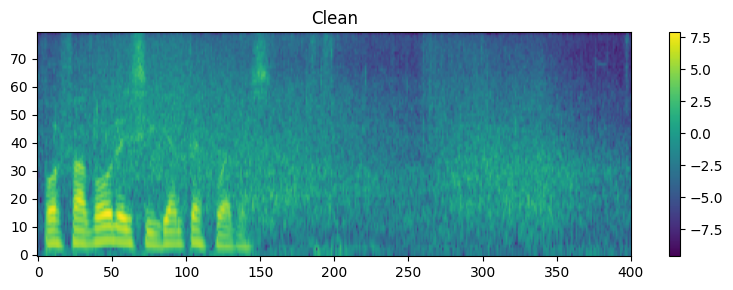

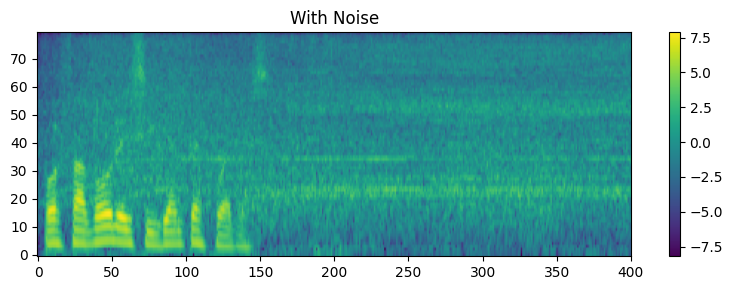

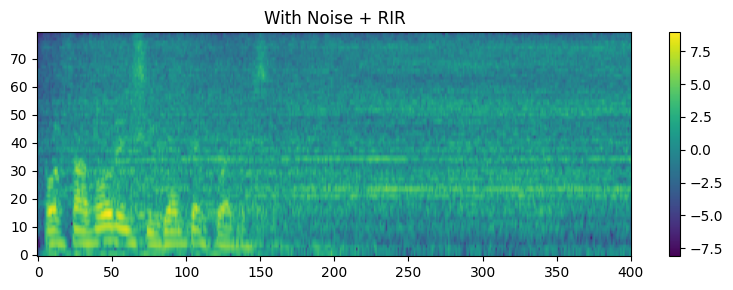

In [7]:
x, _ = trainset[0]

plot_spectrogram(x, "Clean")
display(Audio(x, rate=16000))

x_noise = NoiseAug(prob=1.0)(x.copy())
plot_spectrogram(x_noise, "With Noise")
display(Audio(x_noise, rate=16000))

x_noise_rir = RIRAug(prob=1.0)(x_noise.copy())
plot_spectrogram(x_noise_rir, "With Noise + RIR")
display(Audio(x_noise_rir, rate=16000))

## 1.3
Reutilice el tokenizador de la tarea 1.1, el trainset/testset de la tarea 1.2 y el contenido del cuaderno part3/run21 para implementar el entrenamiento y test de la tarea de fechas con los ficheros: fechas2_train.es.csv y fechas2_test.es.csv. <br>
Compruebe como se hace en el cuaderno la salida generada para algunos ejemplos de test y la visualización del modelo de atención y mida la tasa de error total WER en test. <br>
Si el modelo se entrena muy lento por falta de GPU no hace falta que se hagan muchas iteraciones completas de los datos, lo que se valora es el código. <br>
Puede usar también el frontend preentrenado que se muestra en el cuaderno parte3/run12 para mejorar las prestaciones.

### Spanish Version Training

In [8]:
# vocab_size = len(tokenizer.word2index)

# model = AudioTransformer(
#     vocab_size=vocab_size,
#     d_model=256,
#     nb_layers=8,
#     d_ff=512,
#     n_heads=8,
#     d_head=32,
#     dropout=0.1,
#     seq_len=SEQ_LEN
# )

# model.to(device)
# opt = torch.optim.Adam(model.parameters(), lr=3e-4)
# model.train()

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
# for e in range(NB_EPOCHS):
#     avg_loss = 0
#     for x, y in trainloader:
#         x = x.to(device)
#         y = y.to(device)
#         opt.zero_grad()
#         pad_idx = tokenizer.word2index['<pad>']
#         loss = model.loss(x, y, pad_idx=pad_idx)
#         loss.backward()
#         opt.step()
#         avg_loss += loss.item()
#     print('epoch %d/%d: avg_loss: %.2f' % (e,NB_EPOCHS,avg_loss/len(trainloader)))
       
# torch.save([model, opt], 'model_es.pt')

In [9]:
def evaluate_wer(model, dataset, tokenizer, gen_mode = 'greedy'):
    total_wer = 0.0

    for i in range(len(dataset)):
        x, y = dataset[i]

        ref = tokenizer.decode(y)
        if gen_mode == 'greedy':
            hyp_ids = model.generate(x.unsqueeze(0), tokenizer)
        elif gen_mode == 'sampling':
            hyp_ids = model.generate_sampling(x.unsqueeze(0), tokenizer)
        elif gen_mode == 'topk':
            hyp_ids = model.generate_topk(x.unsqueeze(0), tokenizer)
        elif gen_mode == 'beam':
            hyp_ids = model.generate_beam_search(
                x.unsqueeze(0), tokenizer, beam_size=5
            )
        hyp = tokenizer.decode(hyp_ids)

        total_wer += wer(ref, hyp)

    return total_wer / len(dataset)


In [10]:
model, opt = torch.load(
    'model_es.pt',
    map_location=device,
    weights_only=False 
)

model.to(device)
model.eval()

AudioTransformer(
  (fe): AudioFeatures(
    (fe): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (spec_aug): SpecAug()
    (linear): Linear(in_features=80, out_features=256, bias=True)
  )
  (enc): Encoder(
    (att): ModuleList(
      (0-7): 8 x SelfAttention(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (q_linear): Linear(in_features=256, out_features=256, bias=True)
        (v_linear): Linear(in_features=256, out_features=256, bias=True)
        (k_linear): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (ff): ModuleList(
      (0-7): 8 x FeedForward(
        (ff): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=256, out_features=512, bias=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplac

In [11]:
def show_test_examples(model, dataset, tokenizer, device, n=5):
    model.eval()

    for i in range(n):
        x, y = dataset[i]

        ref = tokenizer.decode(y)
        hyp_ids = model.generate(x.unsqueeze(0).to(device), tokenizer)
        hyp = tokenizer.decode(hyp_ids)

        print(f"Example {i+1}")
        print("REF:", ref)
        print("HYP:", hyp)
        print("-" * 40)

show_test_examples(model, testset, tokenizer, device, n=5)

Example 1
REF: pasado mañana gracias
HYP: pasado mañana gracias
----------------------------------------
Example 2
REF: por favor en un par de días
HYP: por favor en un par de días
----------------------------------------
Example 3
REF: por favor en un par de días
HYP: por favor en un par de días
----------------------------------------
Example 4
REF: este jueves gracias
HYP: este jueves gracias
----------------------------------------
Example 5
REF: por favor el miércoles siguiente
HYP: por favor el miércoles siguiente
----------------------------------------


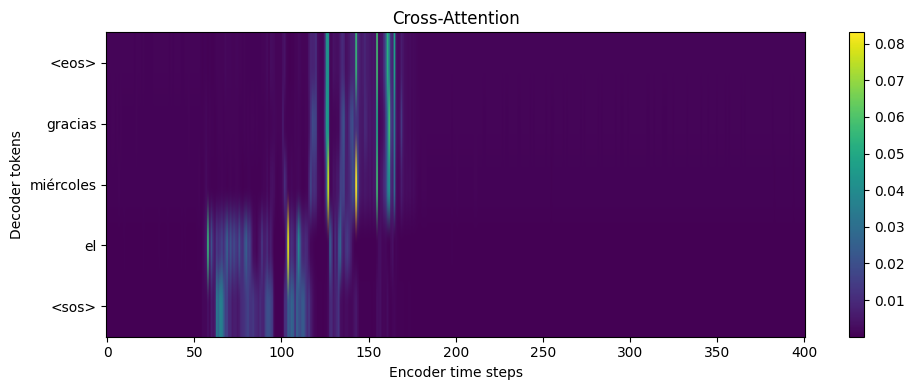

In [12]:
def get_attention(model, x, y):
    model.eval()
    with torch.no_grad():
        enc = model.encoder(x.unsqueeze(0).to(device))

        y_emb = model.emb(y.unsqueeze(0).to(device))
        x_dec = y_emb + model.dec.pos[:, :y_emb.size(1), :]

        att_weights = None
        for att, cross_att, ff in zip(
            model.dec.att,
            model.dec.cross_att,
            model.dec.ff
        ):
            x_dec = x_dec + att(x_dec)
            out, att_weights = cross_att(x_dec, enc)
            x_dec = x_dec + out
            x_dec = x_dec + ff(x_dec)

    return att_weights[0]  # [heads, tgt_len, src_len]

def plot_attention(att, tokenizer, hyp_tokens):
    att = att.mean(0).cpu().numpy()  # average over heads

    plt.figure(figsize=(10,4))
    plt.imshow(att, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel("Encoder time steps")
    plt.ylabel("Decoder tokens")
    plt.yticks(
        range(len(hyp_tokens)),
        [tokenizer.index2word[t] for t in hyp_tokens]
    )
    plt.title("Cross-Attention")
    plt.tight_layout()
    plt.show()

x, y = testset[random.randint(0, len(testset)-1)]

hyp_ids = model.generate(x.unsqueeze(0).to(device), tokenizer)
att = get_attention(model, x, torch.tensor(hyp_ids))

plot_attention(att, tokenizer, hyp_ids)

In [13]:
wer_baseline = evaluate_wer(model, testset, tokenizer, 'greedy')
print(f"WER baseline:   {wer_baseline:.3f}")

## Optional 1
wer_baseline = evaluate_wer(model, testset, tokenizer, 'sampling')
print(f"WER baseline - sampling:   {wer_baseline:.3f}")

## Optional 2
wer_baseline = evaluate_wer(model, testset, tokenizer, 'topk')
print(f"WER baseline - topk:   {wer_baseline:.3f}")

WER baseline:   0.021
WER baseline - sampling:   0.039
WER baseline - topk:   0.035


In [14]:
# Optional 3
wer_baseline = evaluate_wer(model, testset, tokenizer, 'beam')
print(f"WER baseline - beam:   {wer_baseline:.3f}")

WER baseline - topk:   0.022


In [15]:
en_tokenizer = WordTokenizer('fechas2/fechas2_train.en.csv')
en_tokenizer.build_vocab('fechas2/fechas2_test.en.csv')

trainset_en = TrainDataset(
    'fechas2/fechas2_train.en.csv',
    en_tokenizer,
    transform=[
        NoiseAug(prob=0.5),
        RIRAug(prob=0.5)
    ]
)

testset_en = TestDataset(
    'fechas2/fechas2_test.en.csv',
    en_tokenizer
)

10000
1000


In [16]:
# en_vocab_size = len(en_tokenizer.word2index)

# model_en = AudioTransformer(
#     vocab_size=en_vocab_size,
#     d_model=256,
#     nb_layers=8,
#     d_ff=512,
#     n_heads=8,
#     d_head=32,
#     dropout=0.1,
#     seq_len=SEQ_LEN
# )

# model_en.to(device)
# opt_en = torch.optim.Adam(model_en.parameters(), lr=3e-4)
# model_en.train()

# trainloader_en = torch.utils.data.DataLoader(trainset_en, batch_size=BATCH_SIZE, shuffle=True)
# for e in range(NB_EPOCHS):
#     avg_loss = 0
#     for x, y in trainloader_en:
#         x = x.to(device)
#         y = y.to(device)
#         opt_en.zero_grad()
#         pad_idx = en_tokenizer.word2index['<pad>']
#         loss = model_en.loss(x, y, pad_idx=pad_idx)
#         loss.backward()
#         opt_en.step()
#         avg_loss += loss.item()
#     print('epoch %d/%d: avg_loss: %.2f' % (e,NB_EPOCHS,avg_loss/len(trainloader_en)))
       
# torch.save([model_en, opt_en], 'model_en.pt')

In [17]:
model_en, opt_en = torch.load(
    'model_en.pt',
    map_location=device,
    weights_only=False 
)

model_en.to(device)
model_en.eval()

AudioTransformer(
  (fe): AudioFeatures(
    (fe): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (spec_aug): SpecAug()
    (linear): Linear(in_features=80, out_features=256, bias=True)
  )
  (enc): Encoder(
    (att): ModuleList(
      (0-7): 8 x SelfAttention(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (q_linear): Linear(in_features=256, out_features=256, bias=True)
        (v_linear): Linear(in_features=256, out_features=256, bias=True)
        (k_linear): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (ff): ModuleList(
      (0-7): 8 x FeedForward(
        (ff): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=256, out_features=512, bias=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplac

In [18]:
wer_baseline = evaluate_wer(model_en, testset_en, en_tokenizer, 'greedy')
print(f"WER baseline (English):   {wer_baseline:.3f}")

## Optional 1
wer_baseline = evaluate_wer(model_en, testset_en, en_tokenizer, 'sampling')
print(f"WER baseline (English) - sampling:   {wer_baseline:.3f}")

## Optional 2
wer_baseline = evaluate_wer(model_en, testset_en, en_tokenizer, 'topk')
print(f"WER baseline (English) - topk:   {wer_baseline:.3f}")

WER baseline (English):   0.013
WER baseline (English) - sampling:   0.018
WER baseline (English) - topk:   0.024


In [19]:
# Optional 3
wer_baseline = evaluate_wer(model_en, testset_en, en_tokenizer, 'beam')
print(f"WER baseline (English) - beam:   {wer_baseline:.3f}")

WER baseline (English) - beam:   0.012
